In [1]:
%matplotlib inline

import os
import glob

import numpy as np
import pandas as pd
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras import backend as K

Using TensorFlow backend.


In [2]:
def load_image(filename, target=224):
    img = Image.open(filename)
    width, height = img.size
    min_factor = min(width/float(target), height/float(target))
    new_width, new_height = int(round(width/min_factor)), int(round(height/min_factor))
    img = img.resize((new_width, new_height), Image.BILINEAR)
    x = np.array(img, dtype="uint8")
    if new_width > target:
        offset = (new_width - target) // 2
        return x[:,offset:(offset+target),:]
    if new_height > target:
        offset = (new_height - target) // 2
        return x[offset:(offset+target),:,:]
    return x

In [3]:
TARGET = 224
DATADIR = "data/dog_breed/"
LABEL_FILENAME = os.path.join(DATADIR, "labels.csv")

test_files = glob.glob(os.path.join(DATADIR, "test/*.jpg"))
label_df = pd.read_csv(LABEL_FILENAME)
class_num = label_df.breed.nunique()
y = label_df.breed.tolist()

if os.path.isfile(os.path.join(DATADIR, "X.npy")):
    X = np.load(os.path.join(DATADIR, "X.npy"))
else:
    X = np.zeros((label_df.shape[0], TARGET, TARGET, 3), dtype="uint8")
    for i, row in label_df.iterrows():
        X[i] = load_image(os.path.join(DATADIR, "train", "{0}.jpg".format(row["id"])))
    np.save(os.path.join(DATADIR, "X"), X)

In [4]:
# construct feature mapper
base_model = InceptionResNetV2(weights="imagenet", include_top=True)
vector_out = base_model.get_layer("avg_pool")
feature_model = Model(inputs=base_model.input, outputs=vector_out.output)

if os.path.isfile(os.path.join(DATADIR, "X_reduced.npy")):
    X_reduced = np.load(os.path.join(DATADIR, "X_reduced.npy"))
else:
    X_reduced = feature_model.predict(X/255.0)
    np.save(os.path.join(DATADIR, "X_reduced"), X_reduced)

In [5]:
def display_most_similar_images(x, n=5):
    feat = feature_model.predict(x[np.newaxis,:,:,:])[0]
    score_pairs = [(i, np.linalg.norm(X_reduced[i] - feat)) for i in range(X.shape[0])]
    sorted_pairs = sorted(score_pairs, key=lambda x:x[1], reverse=False)
    for idx, _ in sorted_pairs[:n]:
        filename = os.path.join(DATADIR, "train", "{0}.jpg".format(label_df.loc[idx]["id"]))
        plt.imshow(load_image(filename))
        plt.show()

Input image:


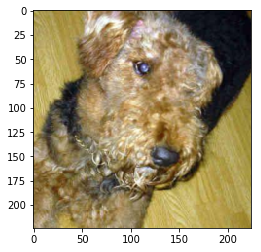

Output image:


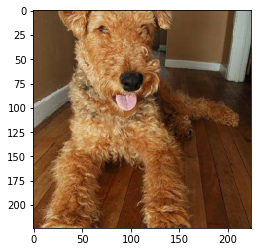

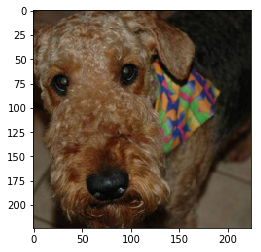

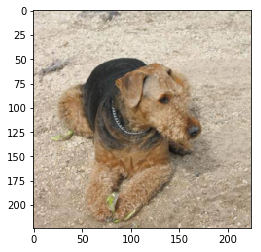

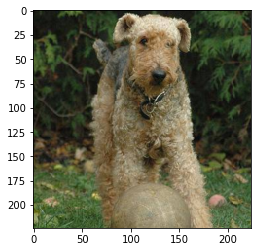

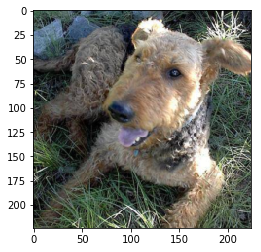

In [6]:
x = load_image(test_files[0])/255.0
print "Input image:"
plt.imshow(x)
plt.show()
print "Output image:"
display_most_similar_images(x)